In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = torch.tensor(iris['data'], dtype=torch.float64)
y = torch.tensor(iris['target'], dtype=torch.float64)
names = iris['target_names']
feature_names = iris['feature_names']

# one hot-encoding of y
y = utils.int_to_onehot(y)

# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

print("maximal elements:")
print(torch.max(X_scaled.flatten()))
print(torch.max(-X_scaled.flatten()))

maximal elements:
tensor(1.5708, dtype=torch.float64)
tensor(1.5708, dtype=torch.float64)


In [5]:
# -----------------------------------------

In [6]:
def train(dataloader, model, loss_fn, optimizer, printing=False):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #print(pred)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if printing == True:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                for param_group in optimizer.param_groups:
                    print("lr: ", param_group['lr'])
    return loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

In [7]:
train_data_list = []
for i in range(len(X_train)):
    data_point = (X_train[i], y_train[i])
    train_data_list.append(data_point)

test_data_list = []
for i in range(len(X_test)):
    data_point = (X_test[i], y_test[i])
    test_data_list.append(data_point)

In [8]:
train_dataloader = DataLoader(train_data_list, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=200, shuffle=True)

loss_fn = nn.CrossEntropyLoss()

In [9]:
NN_loss = []
NN_test_loss = []
NN_test_accuracy = []
dim = X_scaled[0].shape[0]

for max_freq in range(1, 10+1):
    W = utils.freq_generator(max_freq, dim).to(device)
    model = fm.Fourier_model(W, output_dim=3)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-3)

    epochs = 10000
    for t in tqdm(range(epochs)):
        # print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        # test(test_dataloader, model, loss_fn)
        # scheduler.step()
    print("Done!")
    NN_loss.append(train(train_dataloader, model, loss_fn, optimizer, printing=True))
    NN_test_loss.append(test(test_dataloader, model, loss_fn)[0])
    NN_test_accuracy.append(test(test_dataloader, model, loss_fn)[1])

100%|██████████| 10000/10000 [00:12<00:00, 817.73it/s]


Done!
loss: 0.033572  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.159893 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.159893 



100%|██████████| 10000/10000 [00:11<00:00, 851.86it/s]


Done!
loss: 0.007729  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.478321 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.478321 



100%|██████████| 10000/10000 [00:12<00:00, 819.66it/s]


Done!
loss: 0.000352  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 96.7%, Avg loss: 1.085059 

Test Error: 
 Accuracy: 96.7%, Avg loss: 1.085059 



100%|██████████| 10000/10000 [00:27<00:00, 358.38it/s]


Done!
loss: 0.000036  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 96.7%, Avg loss: 1.167039 

Test Error: 
 Accuracy: 96.7%, Avg loss: 1.167039 



100%|██████████| 10000/10000 [00:35<00:00, 282.80it/s]


Done!
loss: 0.000007  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 96.7%, Avg loss: 1.274359 

Test Error: 
 Accuracy: 96.7%, Avg loss: 1.274359 



100%|██████████| 10000/10000 [00:49<00:00, 203.10it/s]


Done!
loss: 0.000002  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 96.7%, Avg loss: 1.232087 

Test Error: 
 Accuracy: 96.7%, Avg loss: 1.232087 



100%|██████████| 10000/10000 [01:20<00:00, 124.18it/s]


Done!
loss: 0.000001  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 93.3%, Avg loss: 1.104774 

Test Error: 
 Accuracy: 93.3%, Avg loss: 1.104774 



100%|██████████| 10000/10000 [02:02<00:00, 81.73it/s]


Done!
loss: 0.000000  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 93.3%, Avg loss: 1.094707 

Test Error: 
 Accuracy: 93.3%, Avg loss: 1.094707 



100%|██████████| 10000/10000 [04:00<00:00, 41.56it/s]


Done!
loss: 0.000000  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.898067 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.898067 



100%|██████████| 10000/10000 [07:58<00:00, 20.92it/s]


Done!
loss: 0.000000  [    0/  120]
lr:  0.005
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.452683 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.452683 



In [10]:
save = True
save_path = "../data/IRIS_04/"
if save == True:
    np.save(save_path+"NN_loss.npy", np.array(NN_loss))
    np.save(save_path+"NN_test_loss.npy", np.array(NN_test_loss))
    np.save(save_path+"NN_test_accuracy.npy", np.array(NN_test_accuracy))

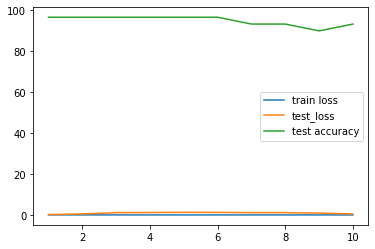

In [12]:
w = np.arange(1, 10+1, 1)

plt.plot(w, NN_loss, label="train loss")
plt.plot(w, NN_test_loss, label="test_loss")
plt.plot(w, NN_test_accuracy, label="test accuracy")
plt.legend()
#plt.ylim(0, 100)